# Namaste! So, what is our project about?

### Musical Genre Classification of Audio Signals.

- Citation: Tzanetakis, George, and Perry Cook. "Musical genre classification of audio signals," <br>IEEE Transactions on speech and audio processing, 2002.
- Link: https://www.cs.cmu.edu/~gtzan/work/pubs/tsap02gtzan.pdf

<img src="img/original-paper.png" align="left" width="500"/>

### Import Libraries

In [1]:
%matplotlib inline
import librosa
import pandas as pd
import numpy as np
import librosa.display
import sklearn
import matplotlib.pyplot as plt
import IPython.display as ipd
import os, glob

### Configurations

In [2]:
config = {
    "dataset": {
#         "input": "test-dataset",
#         "output": "test-data"
        "input": "music-genres-dataset",
        "output": "music-data"
    },
    "counter": 0,
    "max_counter": 5,
    "persist": False
}

### Load all music files and extract their IDs and genres

In [3]:
music_data = dict()
for filepath in glob.iglob('data/' + config["dataset"]["input"] + '/**', recursive=True):
    if os.path.isfile(filepath):
        # Check if it is a music file
        if filepath.endswith(".wav"):
            music_data[filepath] = dict()
            music_data[filepath]["filepath"] = filepath
            music_data[filepath]["filename"] = filepath.rsplit('/',1)[1]
            music_data[filepath]["genre"] = "UNKNOWN" if "test" in config["dataset"]["input"] else music_data[filepath]["filename"].split(".",1)[0]
            
            config["counter"] += 1
            if config["counter"] == config["max_counter"]:
                break
            

### No. of Music files

In [4]:
len(music_data)

5

### It has the following Genres:

- Pop
- Blues
- Classical
- Country
- Disco
- Hiphop
- Jazz
- Metal
- Reggae
- Rock

### Let's analyze one SAMPLE_FILE and explore the features it provides..

In [5]:
SAMPLE_FILE = list(music_data.keys())[0]
SAMPLE_FILE

'data/music-genres-dataset/pop/pop.00027.wav'

### Play audio

In [6]:
ipd.Audio(music_data[SAMPLE_FILE]["filepath"])

### Duration

In [7]:
for filepath in music_data.keys():
    music_data[filepath]["duration"] = librosa.get_duration(filename=filepath)

# Show for a sample file
music_data[SAMPLE_FILE]['duration']

30.00018140589569

## What does an audio signal comprise?

It is a three-dimensional signal in which three axes represent time, amplitude and frequency.

<img src="img/sound-components.png" width="500"/>

### Waveform

A Waveplot lets us know the loudness of the audio at a given time. 

Note: The recommended sampling rate and also the default is **22kHz**. We are not overriding it.

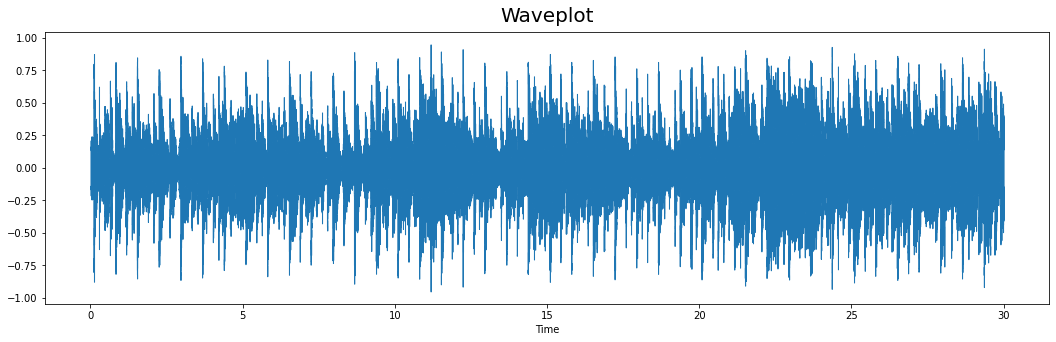

In [8]:
for filepath in music_data.keys():
    music_data[filepath]["waveform"] = music_data[filepath]["waveform"], music_data[filepath]["sampling_rate"] = librosa.load(filepath)

# Show for a sample file
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=1)
plt.title("Waveplot", fontsize=20, pad=10)
plt.savefig("img/waveplot.png")
plt.show()

### Beats, Tempo, and Predominant local pulse (PLP)

- **Beat**: is the regularly occurring pattern of rhythmic stresses in music.
- **Tempo**: is the speed of the Beat, usually expressed in Beats Per Minute (BPM)
- **Predominant local pulse (PLP)** analyzes the frequency domain to find a locally stable tempo for each frame.

In [9]:
for filepath in music_data.keys():
    music_data[filepath]["beats"] = librosa.beat.beat_track(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0]
    music_data[filepath]["tempo"] = librosa.beat.tempo(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0]
    music_data[filepath]["plp"] = librosa.beat.plp(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0]
    
# Show for a sample file
print(f"Beats: {music_data[SAMPLE_FILE]['beats']}")
print(f"Tempo (Beats per minute): {music_data[SAMPLE_FILE]['tempo']}")
print(f"Predominant Local Pulse (PLP): {music_data[SAMPLE_FILE]['plp']}")


Beats: 83.35433467741936
Tempo (Beats per minute): 83.35433467741936
Predominant Local Pulse (PLP): 0.0


### Spectrogram

- A spectrogram shows different frequencies playing at a particular time along with it’s amplitude.
- It does so by converting the audio data into short term Fourier transform!

Mean of Spectrogram: -4.269062519073486


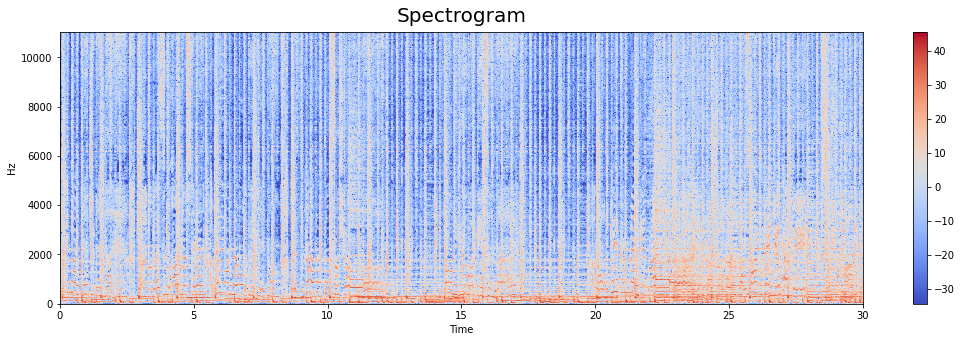

In [10]:
for filepath in music_data.keys():
    X = librosa.stft(music_data[filepath]['waveform'])
    Xdb = librosa.amplitude_to_db(abs(X))
    music_data[filepath]["spectrogram"] = np.mean(Xdb)

# Show for a sample file
print(f'Mean of Spectrogram: {music_data[SAMPLE_FILE]["spectrogram"]}')

# Display Spectrogram
X = librosa.stft(music_data[SAMPLE_FILE]['waveform'])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(18, 5))
librosa.display.specshow(Xdb, sr=music_data[SAMPLE_FILE]["sampling_rate"], x_axis='time', y_axis='hz') 
plt.colorbar()
plt.title("Spectrogram", fontsize=20, pad=10)
plt.savefig("img/spectrogram.png")
plt.show()

### Chromagram

- It represents the intensity of the twelve distinctive pitch classes that are used to study music. 
- They can be employed in the differentiation of the pitch class profiles between audio signals.

Mean of Chromagram: 0.3776119649410248


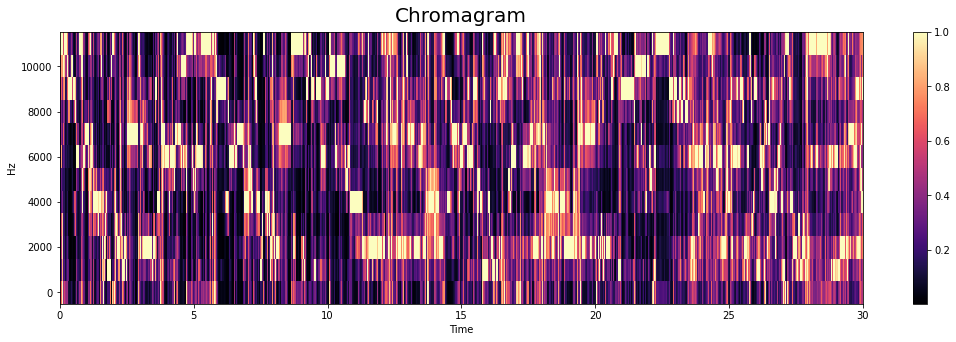

In [11]:
for filepath in music_data.keys():
    music_data[filepath]["chromagram"] = np.mean(librosa.feature.chroma_stft(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate']))

# Show for a sample file
print(f'Mean of Chromagram: {music_data[SAMPLE_FILE]["chromagram"]}')

# Display Chromagram
X = librosa.feature.chroma_stft(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])
plt.figure(figsize=(18, 5))
librosa.display.specshow(X, sr=music_data[SAMPLE_FILE]["sampling_rate"], x_axis='time', y_axis='hz') 
plt.colorbar()
plt.title("Chromagram", fontsize=20, pad=10)
plt.savefig("img/chromagram.png")
plt.show()

### Tempogram

- Tempo can vary locally within a piece. 
- Therefore, the tempogram is a feature matrix which indicates the prevalence of certain tempi at each moment in time.

Mean of Tempogram: 0.1270049797896095


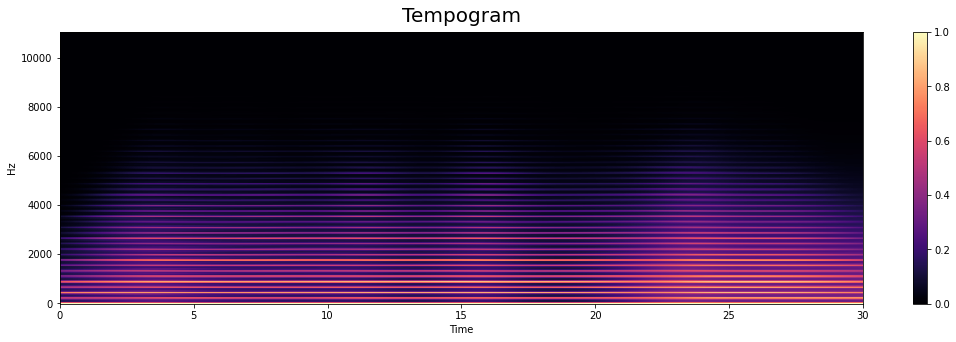

In [12]:
for filepath in music_data.keys():
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'], hop_length=hop_length)
    music_data[filepath]["tempogram"] = np.mean(librosa.feature.tempogram(onset_envelope=oenv, sr=music_data[filepath]['sampling_rate'], hop_length=hop_length))

# Show for a sample file
print(f'Mean of Tempogram: {music_data[SAMPLE_FILE]["tempogram"]}')

# Display Tempogram
hop_length = 512
oenv = librosa.onset.onset_strength(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], hop_length=hop_length)
X = librosa.feature.tempogram(onset_envelope=oenv, sr=music_data[SAMPLE_FILE]['sampling_rate'], hop_length=hop_length)
plt.figure(figsize=(18, 5))
librosa.display.specshow(X, sr=music_data[SAMPLE_FILE]["sampling_rate"], x_axis='time', y_axis='hz') 
plt.colorbar()
plt.title("Tempogram", fontsize=20, pad=10)
plt.savefig("img/tempogram.png")
plt.show()

### Zero Crossings and Zero Crossing Rate

- The zero crossing rate is the rate of sign-changes along a signal, i.e., the rate at which the signal changes from positive to negative or back. 
- This feature has been used heavily in both speech recognition and music information retrieval. 
- It usually has higher values for highly percussive sounds like those in metal and rock.

In [13]:
for filepath in music_data.keys():
    music_data[filepath]["zero_crossings"] = sum(librosa.zero_crossings(music_data[filepath]['waveform'], pad=False))
    music_data[filepath]["zero_crossing_rate"] = np.mean(librosa.feature.zero_crossing_rate(music_data[filepath]['waveform'], pad=False))
    
# Show for a sample file
print(f'Number of Zero crossings: {music_data[SAMPLE_FILE]["zero_crossings"]}')
print(f'Mean of Zero crossing rate: {music_data[SAMPLE_FILE]["zero_crossing_rate"]}')

Number of Zero crossings: 67487
Mean of Zero crossing rate: 0.1018672509425754


### Spectral Centroid

- It indicates where the "centre of mass" for a sound is located.
- It is calculated as the weighted mean of the frequencies present in the sound. 
- If the frequencies in music are same throughout then spectral centroid would be around a centre and if there are high frequencies at the end of sound then the centroid would be towards its end.

Mean of Spectral Centroid: 2682.2841411936142


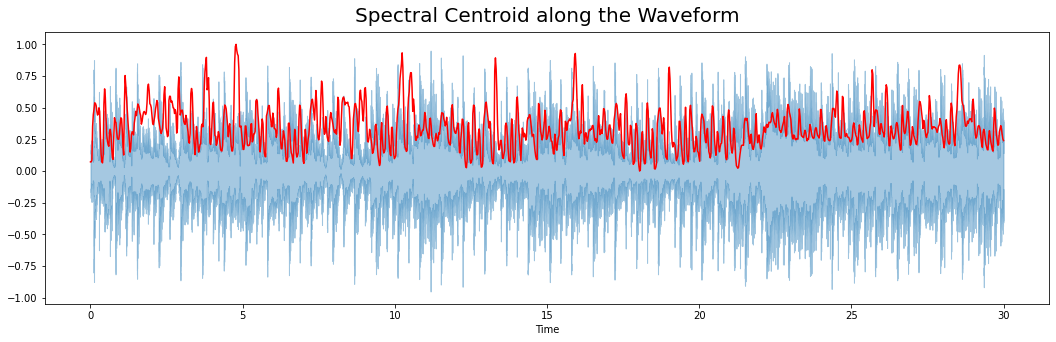

In [14]:
for filepath in music_data.keys():
    spectral_centroids = librosa.feature.spectral_centroid(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0]
    music_data[filepath]["spectral_centroid"] = np.mean(spectral_centroids)

    # Computing the time variable for visualization
    frames = range(len(spectral_centroids))
    music_data[filepath]["time_variable"] = librosa.frames_to_time(frames)
    
# Show for a sample file
print(f'Mean of Spectral Centroid: {music_data[SAMPLE_FILE]["spectral_centroid"]}')

# Computing the time variable for visualization
spectral_centroids = librosa.feature.spectral_centroid(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])[0]
frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

# Normalising the spectral centroid for visualisation
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

# Plotting the Spectral Centroid along the waveform
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(spectral_centroids), color='r')

plt.title("Spectral Centroid along the Waveform", fontsize=20, pad=10)
plt.savefig("img/spectral-centroid.png")
plt.show()

### Spectral Rolloff

- It is the per-frame center frequency for a spectrogram bin such that at least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and the bins below. 
- This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent to a value close to 1 (or 0).

Mean of Spectral Rolloff: 5956.0789882721865


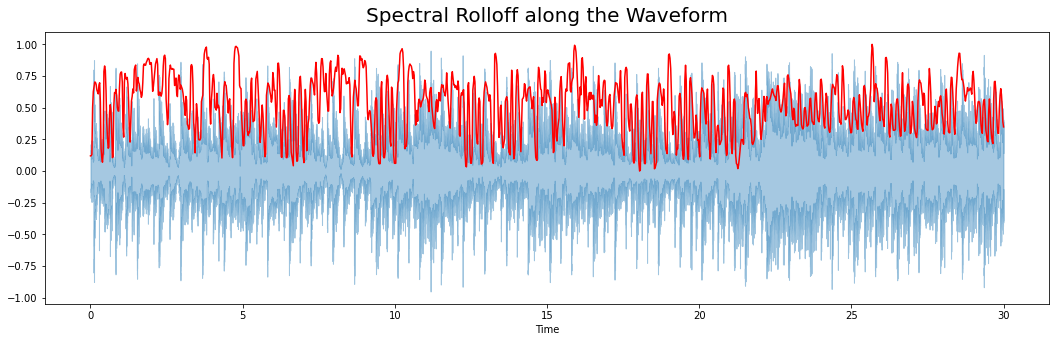

In [15]:
for filepath in music_data.keys():
    music_data[filepath]["spectral_rolloff"] = np.mean(librosa.feature.spectral_rolloff(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0])

# Show for a sample file
print(f'Mean of Spectral Rolloff: {music_data[SAMPLE_FILE]["spectral_rolloff"]}')

# Plotting the Spectral Rolloff along the waveform
spectral_rolloff = librosa.feature.spectral_rolloff(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])[0]
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='r')

plt.title("Spectral Rolloff along the Waveform", fontsize=20, pad=10)
plt.savefig("img/spectral-rolloff.png")
plt.show()

### Spectral Contrast

- Each frame of a spectrogram S is first divided into sub-bands. 
- Then, for each sub-band, the energy contrast is estimated by comparing the mean energy in the top quantile (peak energy) to that of the bottom quantile (valley energy). 
- High contrast values generally correspond to clear, narrow-band signals, while low contrast values correspond to broad-band noise.

Mean of Spectral Contrast: 22.257477751200955


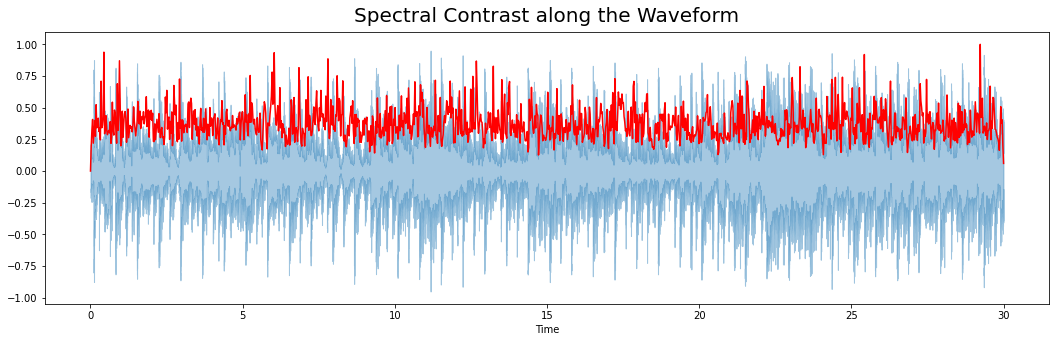

In [16]:
for filepath in music_data.keys():
    music_data[filepath]["spectral_contrast"] = np.mean(librosa.feature.spectral_contrast(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0])
    
# Show for a sample file
print(f'Mean of Spectral Contrast: {music_data[SAMPLE_FILE]["spectral_contrast"]}')

# Plotting the Spectral Contrast along the waveform
spectral_contrast = librosa.feature.spectral_contrast(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])[0]
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(spectral_contrast), color='r')

plt.title("Spectral Contrast along the Waveform", fontsize=20, pad=10)
plt.savefig("img/spectral-contrast.png")
plt.show()

### Spectral Bandwidth

- Also called the spectral spread.
- It is the spectral range of interest around the centroid, that is, the variance from the spectral centroid.
- It is directly correlated with the perceived timbre.

Mean of Spectral Bandwidth: 2923.9677291945763


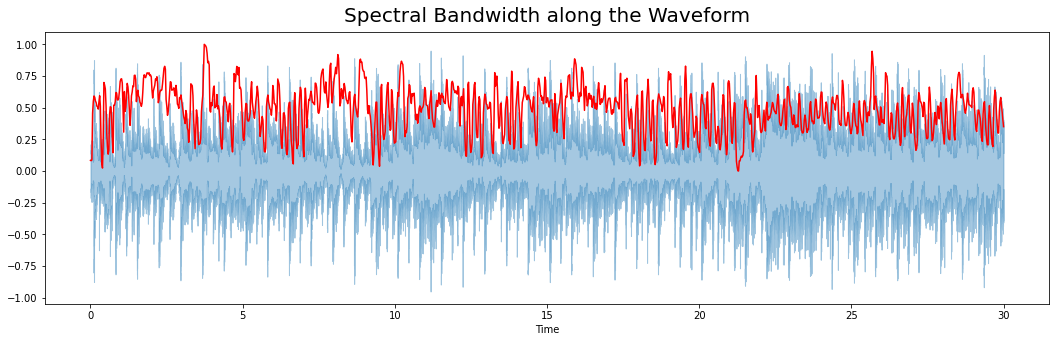

In [17]:
for filepath in music_data.keys():
    music_data[filepath]["spectral_bandwidth"] = np.mean(librosa.feature.spectral_bandwidth(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate'])[0])
    
# Show for a sample file
print(f'Mean of Spectral Bandwidth: {music_data[SAMPLE_FILE]["spectral_bandwidth"]}')

# Plotting the Spectral Bandwidth along the waveform
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])[0]
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(spectral_bandwidth), color='r')

plt.title("Spectral Bandwidth along the Waveform", fontsize=20, pad=10)
plt.savefig("img/spectral-bandwidth.png")
plt.show()

### Spectral Flatness

- Also called the Tonality Coefficient.
- It is a measure to quantify how much noise-like a sound is, as opposed to being tone-like.
- A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. It is often converted to decibel.

Mean of Spectral Flatness: 0.047302521765232086


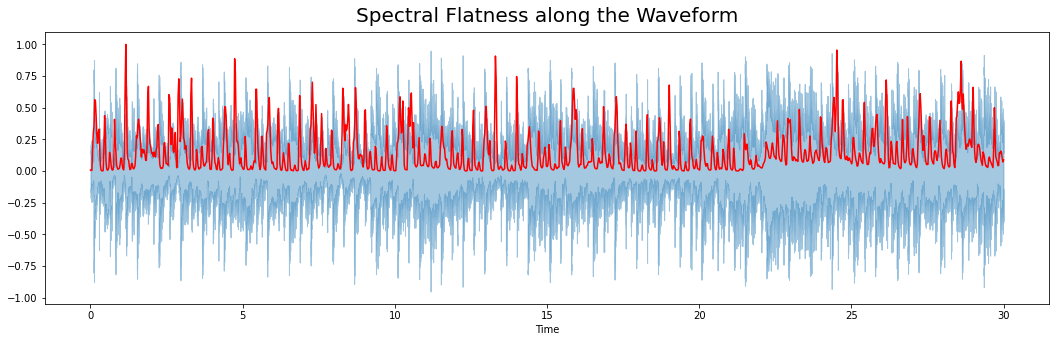

In [18]:
for filepath in music_data.keys():
    music_data[filepath]["spectral_flatness"] = np.mean(librosa.feature.spectral_flatness(y=music_data[filepath]['waveform'])[0])
    
# Show for a sample file
print(f'Mean of Spectral Flatness: {music_data[SAMPLE_FILE]["spectral_flatness"]}')

# Plotting the Spectral Flatness along the waveform
spectral_flatness = librosa.feature.spectral_flatness(y=music_data[SAMPLE_FILE]['waveform'])[0]
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(spectral_flatness), color='r')

plt.title("Spectral Flatness along the Waveform", fontsize=20, pad=10)
plt.savefig("img/spectral-flatness.png")
plt.show()

### RMS (Root Mean Square) Energy

- Compute root-mean-square (RMS) energy for each frame from the audio samples.
- For audio signals, that roughly corresponds to how loud the signal is.

Mean of RMS (Root Mean Square) Energy: 0.1579022854566574


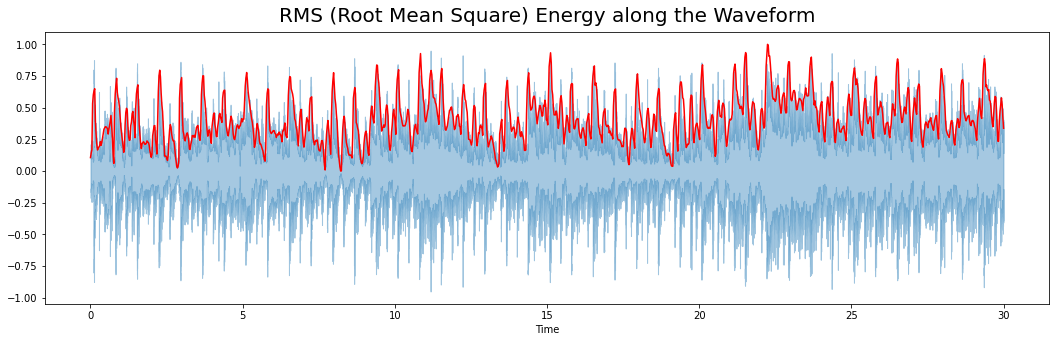

In [19]:
for filepath in music_data.keys():
    music_data[filepath]["rms"] = np.mean(librosa.feature.rms(y=music_data[filepath]['waveform'])[0])
    
# Show for a sample file
print(f'Mean of RMS (Root Mean Square) Energy: {music_data[SAMPLE_FILE]["rms"]}')

# Plotting the Spectral Flatness along the waveform
rms = librosa.feature.rms(y=music_data[SAMPLE_FILE]['waveform'])[0]
plt.figure(figsize=(18, 5))
librosa.display.waveshow(music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'], alpha=0.4)
plt.plot(t, normalize(rms), color='r')

plt.title("RMS (Root Mean Square) Energy along the Waveform", fontsize=20, pad=10)
plt.savefig("img/rms.png")
plt.show()

### MFCC — Mel-Frequency Cepstral Coefficients

- One of the most important method to extract a feature of an audio signal.
- They are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope.

Mean of MFCC — Mel-Frequency Cepstral Coefficients: 2.0804495811462402


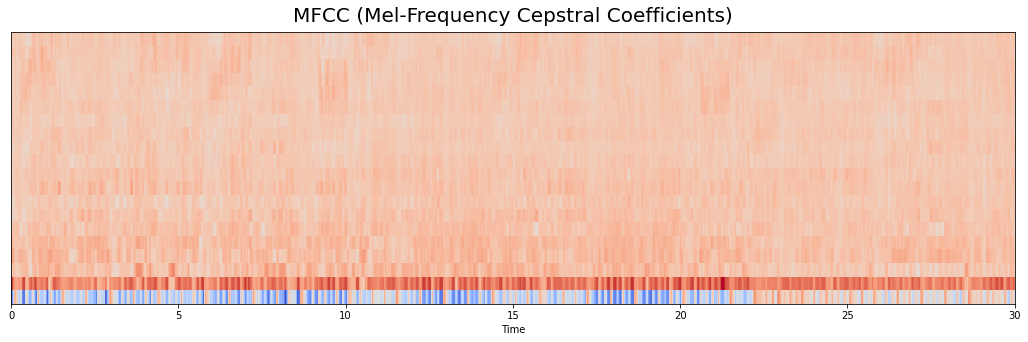

In [20]:
for filepath in music_data.keys():
    music_data[filepath]["mfccs"] = np.mean(librosa.feature.mfcc(y=music_data[filepath]['waveform'], sr=music_data[filepath]['sampling_rate']))
       
# Show for a sample file
print(f'Mean of MFCC — Mel-Frequency Cepstral Coefficients: {music_data[SAMPLE_FILE]["mfccs"]}')

# Displaying the MFCCs:
mfccs = librosa.feature.mfcc(y=music_data[SAMPLE_FILE]['waveform'], sr=music_data[SAMPLE_FILE]['sampling_rate'])
plt.figure(figsize=(18, 5))
librosa.display.specshow(mfccs, sr=music_data[SAMPLE_FILE]['sampling_rate'], x_axis='time')


plt.title("MFCC (Mel-Frequency Cepstral Coefficients)", fontsize=20, pad=10)
plt.savefig("img/mfccs.png")
plt.show()

### Prepare Feature Dataset

In [21]:
df_feature = pd.DataFrame(music_data.values())
df_feature_with_filenames = df_feature.drop(columns=['waveform','time_variable','sampling_rate','duration'])
df_feature_with_filenames.head()

,filepath,filename,genre,beats,tempo,plp,spectrogram,chromagram,tempogram,zero_crossings,zero_crossing_rate,spectral_centroid,spectral_rolloff,spectral_contrast,spectral_bandwidth,spectral_flatness,rms,mfccs
0,data/music-genres-dataset/pop/pop.00027.wav,pop.00027.wav,pop,83.354335,83.354335,0.000000,-4.269063,0.377612,0.127005,67487,0.101867,2682.284141,5956.078988,22.257478,2923.967729,0.047303,0.157902,2.080450
1,data/music-genres-dataset/pop/pop.00033.wav,pop.00033.wav,pop,99.384014,99.384014,0.000000,-3.781867,0.423036,0.158264,90785,0.137010,2835.119375,5944.979313,18.068245,2731.752387,0.061382,0.139896,0.843129
2,data/music-genres-dataset/pop/pop.00032.wav,pop.00032.wav,pop,95.703125,95.703125,0.519045,-4.358516,0.426769,0.121314,151492,0.228641,4225.461049,8483.382577,18.657617,3404.380733,0.125869,0.097861,-0.666234
3,data/music-genres-dataset/pop/pop.00026.wav,pop.00026.wav,pop,75.999540,151.999081,0.000000,-4.899115,0.334962,0.133198,68571,0.103494,2525.591959,5552.801896,23.054193,2848.409561,0.030347,0.195626,2.070004
4,data/music-genres-dataset/pop/pop.00030.wav,pop.00030.wav,pop,95.703125,95.703125,0.472598,0.983008,0.357630,0.140248,98516,0.148679,3070.672741,6653.076965,17.128994,2975.765677,0.075034,0.203093,2.515382


### Prepare Training Dataset: Drop irrelevant columns

In [22]:
df_training_data = df_feature.drop(columns=['waveform','time_variable','filepath','sampling_rate','duration', 'filename'])
df_training_data.head()

,genre,beats,tempo,plp,spectrogram,chromagram,tempogram,zero_crossings,zero_crossing_rate,spectral_centroid,spectral_rolloff,spectral_contrast,spectral_bandwidth,spectral_flatness,rms,mfccs
0,pop,83.354335,83.354335,0.000000,-4.269063,0.377612,0.127005,67487,0.101867,2682.284141,5956.078988,22.257478,2923.967729,0.047303,0.157902,2.080450
1,pop,99.384014,99.384014,0.000000,-3.781867,0.423036,0.158264,90785,0.137010,2835.119375,5944.979313,18.068245,2731.752387,0.061382,0.139896,0.843129
2,pop,95.703125,95.703125,0.519045,-4.358516,0.426769,0.121314,151492,0.228641,4225.461049,8483.382577,18.657617,3404.380733,0.125869,0.097861,-0.666234
3,pop,75.999540,151.999081,0.000000,-4.899115,0.334962,0.133198,68571,0.103494,2525.591959,5552.801896,23.054193,2848.409561,0.030347,0.195626,2.070004
4,pop,95.703125,95.703125,0.472598,0.983008,0.357630,0.140248,98516,0.148679,3070.672741,6653.076965,17.128994,2975.765677,0.075034,0.203093,2.515382


### Save both datasets

In [23]:
if config["persist"]:
    df_feature_with_filenames.to_csv("data/" + config["dataset"]["output"] + "-with-filenames.csv", sep="\t", header=True, index=True)
    df_training_data.to_csv("data/" + config["dataset"]["output"] + ".csv", sep="\t", header=True, index=True)